# ECE 57000 Assignment 5 Exercise

Your Name: Cole Richardson

# Exercise 1: Define classifier that extracts latent representations and visualize representations (**40 points**)

The latent (i.e., hidden) representations generated by a deep neural network are very important concept in deep learning since the latent space is where the most significant features of the dataset are learned and extracted.
In this homework, we will explore the latent representations of a classifier using clustering and nearest neighbor methods.

We provide the code for a simple residual CNN with batchnorm and data loaders.

*  Here, we define a neural network block architecture that does batch normalization after each convolution layer and has a skip connection. You can read more about batch normalization and skip connections in these papers https://arxiv.org/pdf/1502.03167.pdf and https://arxiv.org/pdf/1512.03385.pdf, respectively.
*  In this neural network, the block networks are designed so that the input dimension and the output dimension stay the same. This may not be an optimal design, but it will help us visualize the latent representation later.

In [53]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [54]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

class SimpleResidualBlock(nn.Module):
    def __init__(self, ch_in, mult=4):
        super().__init__()
        self.conv1 = nn.Conv2d(ch_in, mult * ch_in, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(mult * ch_in)

        self.conv2 = nn.Conv2d(mult * ch_in, mult * ch_in, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(mult * ch_in)

        self.conv3 = nn.Conv2d(mult * ch_in, ch_in, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(ch_in)

    def forward(self, x):
        x_ = x.clone()
        x_ = torch.relu(self.bn1(self.conv1(x_)))
        x_ = torch.relu(self.bn2(self.conv2(x_)))
        x_ = torch.relu(self.bn3(self.conv3(x_)))
        x = x + x_
        return x

class SimpleResNet(nn.Module):
    def __init__(self, ch_in, n_blocks=3):
        super().__init__()
        self.residual_layers = nn.ModuleList([SimpleResidualBlock(ch_in) for i in range(n_blocks)])
        self.maxpool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(9, 10)

    def forward(self, x):
        for residual in self.residual_layers:
          x = residual(x)
          x = self.maxpool(x)
        x = x.view(x.shape[0], -1)  # Unravel tensor dimensions
        out = self.fc(x)
        return out

C:\Users\Cole\AppData\Local\Temp\ipykernel_132864\4196534660.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


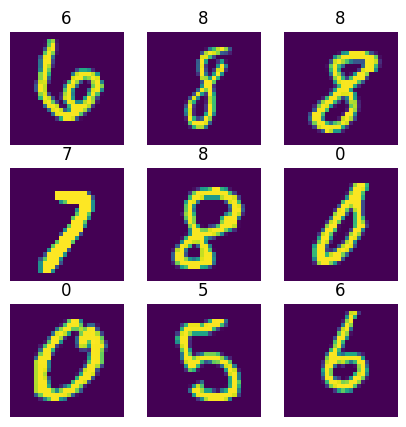

In [55]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Create MNIST datasets
classes = np.arange(10)
transform = torchvision.transforms.Compose(
  [torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create dataloaders
batch_size_train, batch_size_test = 64, 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Show sample images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (5,5))
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image.squeeze(2))
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
    ax[i,j].axis('off')
fig.show()

### Task 1: Inherit the original model class and define a new function returning the same output with the parent's forward function as well as intermediate representations (including the original input)

Specifically, the function below should return the original output from `forward` function of the parent's class and a list of intermediate representations `z_list`. `z_list` should be a Python list with 4 entries corresponding to the original batch and the batch **after each maxpool layer.**


Hints:
* Because of inheritance, you do not need to implement another `__init__` function.
  For those who are not familiar with inheritance, here is the link to get to know
  what Inheritance in Python is: https://www.geeksforgeeks.org/inheritance-in-python/.
* You will want to do the same computation as the original `forward` function
  but add some code to save intermediate representations, i.e., the code should
  output exactly the same thing as the original `forward` function but also return
  intermediate outputs.
* The output of this exercise should be:
```
Representation z0 batch shape = torch.Size([128, 1, 28, 28])
Representation z1 batch shape = torch.Size([128, 1, 14, 14])
Representation z2 batch shape = torch.Size([128, 1, 7, 7])
Representation z3 batch shape = torch.Size([128, 1, 3, 3])
```
* We provide a simple example for a linear model below.

In [56]:
# Trivial example below
class AffineModel(nn.Module):
    def __init__(self, A, b):
        super().__init__()
        self.A, self.b = A, b
    def forward(self, x):
        x = torch.matmul(x, self.A)
        return x + self.b
class ExtractAffineModel(AffineModel):
    def compute_and_extract_representations(self, x):
        z_list = [x]
        x = torch.matmul(x, self.A)
        z_list.append(x)
        return x + self.b, z_list

In [57]:
class SimpleResNetWithRepresentations(SimpleResNet):
    def compute_and_extract_representations(self, x):
        # ----------- <Your code> ---------------
        z_list = [x]
        for residual in self.residual_layers:
            x = residual(x)
            x = self.maxpool(x)
            z_list.append(x)
        x = x.view(x.shape[0], -1)  # Unravel tensor dimensions
        out = self.fc(x)
        # ----------- <End your code> ---------------
        return out, z_list


model = SimpleResNetWithRepresentations(ch_in=1)
model.to(device)
images, labels = next(iter(test_loader))  # get a batch
images = images.to(device)
# Check that outputs match
out, z_list = model.compute_and_extract_representations(images)
assert torch.all(model(images) == out), "Outputs should be the same"
# Check shapes of representations
assert len(z_list) == 4, "Should have length of 4"
assert torch.all(z_list[0] == images), "First entry should be original data"
for zi, z in enumerate(z_list):
    print(f"Representation z{zi} batch shape = {z.shape}")

Representation z0 batch shape = torch.Size([128, 1, 28, 28])
Representation z1 batch shape = torch.Size([128, 1, 14, 14])
Representation z2 batch shape = torch.Size([128, 1, 7, 7])
Representation z3 batch shape = torch.Size([128, 1, 3, 3])


### Task 2: Train the model

Define the train function to train `model` for 4 epochs using the Adam optimizer with a learning rate of 0.01.

Define the test function to print average loss (use the variable `test_loss`) and accuracy (use the variable `correct`).

Test loss needs to be around 0.1-0.3 and Acccuracy needs to be higher than 90% after finishing training.

In [58]:
def train(epoch, model, loss_fn, optimizer):
    model.train()  # we need to set the mode for our model
    for batch_idx, (images, targets) in enumerate(train_loader):
        # ----------- <Your code> ---------------
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        # ----------- <End Your code> ---------------
        if batch_idx % 100 == 0:  # We visulize our output every 10 batches
            print(
                f"Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}"
            )


def test(epoch, model, loss_fn):
    model.eval()  # we need to set the mode for our model
    test_loss = 0  # sum up the loss value
    correct = 0  # sum up the corrected samples
    with torch.no_grad():
        for images, targets in test_loader:
            # ----------- <Your code> ---------------
            images, targets = images.to(device), targets.to(device)
            output = model(images)
            test_loss += loss_fn(output, targets).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            # ----------- <End Your code> ---------------
    test_loss /= len(test_loader.dataset)
    print(
        f"Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%"
    )


import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

max_epoch = 4
for epoch in range(1, max_epoch + 1):
    train(epoch, model, loss_fn, optimizer)
    test(epoch, model, loss_fn)

Epoch 1: [0/60000] Loss: 4.347135066986084
Epoch 1: [6400/60000] Loss: 1.2872416973114014
Epoch 1: [12800/60000] Loss: 0.6682068109512329
Epoch 1: [19200/60000] Loss: 0.4931110441684723
Epoch 1: [25600/60000] Loss: 0.4913020431995392
Epoch 1: [32000/60000] Loss: 0.392508327960968
Epoch 1: [38400/60000] Loss: 0.4294033646583557
Epoch 1: [44800/60000] Loss: 0.38110458850860596
Epoch 1: [51200/60000] Loss: 0.5169232487678528
Epoch 1: [57600/60000] Loss: 0.4869723320007324
Test result on epoch 1: Avg loss is 0.002899026708677411, Accuracy: 88.74%
Epoch 2: [0/60000] Loss: 0.2989705204963684
Epoch 2: [6400/60000] Loss: 0.2800527811050415
Epoch 2: [12800/60000] Loss: 0.43129459023475647
Epoch 2: [19200/60000] Loss: 0.2456553876399994
Epoch 2: [25600/60000] Loss: 0.6942678093910217
Epoch 2: [32000/60000] Loss: 0.15077941119670868
Epoch 2: [38400/60000] Loss: 0.20804446935653687
Epoch 2: [44800/60000] Loss: 0.34791871905326843
Epoch 2: [51200/60000] Loss: 0.21766847372055054
Epoch 2: [57600/600

### Task 3: Visualize the intermediate latent representations

*   Plot the representations of 20 images from the test dataset in a supblots grid of shape (20, 4) (code already given for setting up these subplots) where the rows correspond to samples in the dataset and columns correspond to the representations produced by `compute_and_extract_representations`

Notes:
*   We give code below for normalizing the image and plotting on an axis with a title.
*   Make sure to set `model.eval()` when computing because of the batchnorm layers
*   No title or ylabel is needed in this case.
*   `z_list` is a list of 4 tensors of shape ([B, 1, 28, 28]). **Figure out how to pass through the assertion error and think why the batch dimension cannot be processed together.**

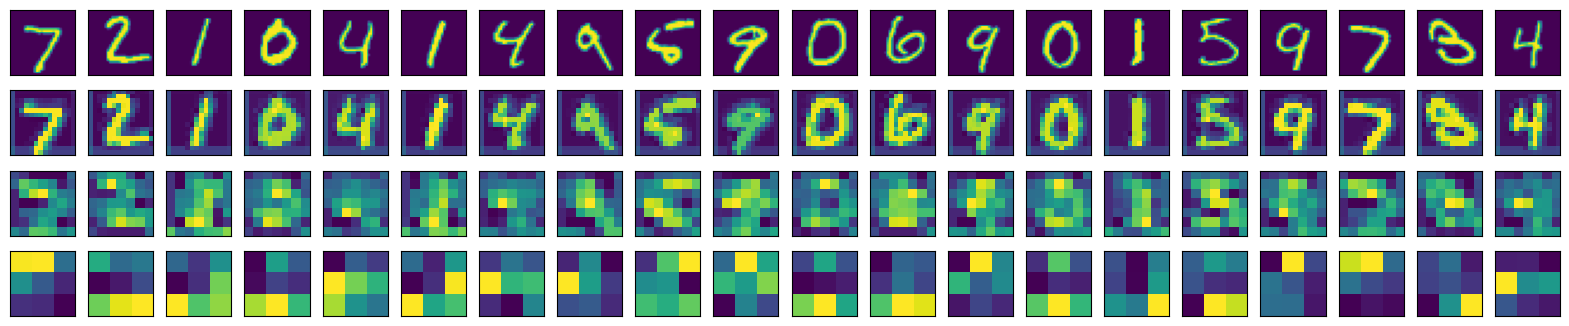

In [59]:
def plot_representation(z, ax):
  # Normalize image for visualization
  assert z.ndim == 3, 'Should be 3 dimensional tensor with C x H x W'
  z = (z - z.min())/(z.max() - z.min())
  if torch.is_tensor(z):  # Convert torch tensor to numpy if needed
    z = z.detach().cpu().numpy()
  ax.imshow(z.transpose((1,2,0)).squeeze(2))
  # Remove ticks and ticklabels to make plot clean
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

n_show = 20
fig, axes_mat = plt.subplots(4, n_show, figsize=[n_show, 4])
# ----------- <Your code> ---------------
model.eval()
with torch.no_grad():
    for i in range(n_show):
        images, targets = next(iter(test_loader))
        images, targets = images.to(device), targets.to(device)
        _, z_list = model.compute_and_extract_representations(images)
        for zi, z in enumerate(z_list):
            plot_representation(z[i], axes_mat[zi, i])
# ----------- <End your code> ---------------

Notice how the representations become more and more abstract as the depth increases.

# Exercise 2: Clustering with different representations (50 points)

### Task 1: Create simple numpy arrays of the representations
To perform further manipulations in numpy and scikit-learn, we will need to create simple numpy arrays for each representation. We provide the code for merging multiple batches. You will need to provide the code for extracting from the given data loader.

* Loop through the data loader and extract representations for each batch
* Append the labels and z_list to corresponding lists
* Break out of loop when the number extracted is n_extract or greater

The output of the merged lists should print the following for both train and test:
```
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1, 3, 3)]
Shape of merged labels
    (200,)
```

In [60]:
def extract_numpy_representations(model: SimpleResNetWithRepresentations, data_loader, n_extract):
  extracted_z_lists = []
  labels_list = []
  # ----------- <Your code> ---------------
  model.eval()
  with torch.no_grad():
    for images, targets in data_loader:
        images, targets = images.to(device), targets.to(device)
        _, z_list = model.compute_and_extract_representations(images)
        extracted_z_lists.append(z_list)
        labels_list.append(targets)
        if len(extracted_z_lists) >= n_extract:
            break
  # ----------- <End your code> ---------------
  # Check extracted_z_lists (type should be tensor)
  print(f'Types of first batch\n    {[type(z) for z in extracted_z_lists[0]]}')
  print(f'Shapes of first batch\n    {[z.shape for z in extracted_z_lists[0]]}')

  # Merge extracted z_lists and labels and make numpy arrays
  z_list_merge_np = [
    np.vstack([
      z_list[i].detach().cpu().numpy()
      for z_list in extracted_z_lists
    ])[:n_extract]  # Extract up to n_extract
    for i in range(len(extracted_z_lists[0]))
  ]
  print(f'Types of merged lists\n    {[type(z) for z in z_list_merge_np]}')
  print(f'Shapes of merged lists\n    {[z.shape for z in z_list_merge_np]}')
  labels_merged_np = np.concatenate([
    labels.detach().cpu().numpy()
    for labels in labels_list
  ])[:n_extract]  # Extract up to n_extract
  print(f'Shape of merged labels\n    {labels_merged_np.shape}')
  return z_list_merge_np, labels_merged_np

# Extract train and test samples
z_list_train, labels_train = extract_numpy_representations(model, train_loader, n_extract=200)
z_list_test, labels_test = extract_numpy_representations(model, test_loader, n_extract=200)
# Extract regular train and test
x_test = z_list_test[0]
x_train = z_list_train[0]

Types of first batch
    [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Shapes of first batch
    [torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 14, 14]), torch.Size([64, 1, 7, 7]), torch.Size([64, 1, 3, 3])]
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1, 3, 3)]
Shape of merged labels
    (200,)
Types of first batch
    [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Shapes of first batch
    [torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 14, 14]), torch.Size([128, 1, 7, 7]), torch.Size([128, 1, 3, 3])]
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1, 3

### Task 2: Perform K-means clustering on different representations

In this task, we will perform kmeans clustering on each of the latent representations of the test set and then evaluate the clustering based on the true class labels.
A good discussion of clustering metrics can be found in [scikit-learn's documentation on clustering metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

* Using scikit-learn's [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) estimator, perform kmeans with $k=10$ and `random_state=0` on the latent representations and extract the cluster labels.
* Use [`sklearn.metrics.adjusted_rand_score`]() to compute a score to evaluate the clustering based on the true class labels.

Notes:
* You will need to reshape the tensors into matrices immediately before passing into sklearn functions (you should keep the original data as is so that the images can be plotted, but just reshape immediately before passing into scikit-learn functions). Specifically, the arrays will have shape (B, C, H, W) and you should reshape to (B, C*H*W) before passing to scikit-learn functions.
* We provide code for plotting and evaluating your clustering.
* Note that clustering is unsupervised. What we're plotting here is the ten different clusters, not the ten different categories of true labels. Thus, the cluster index in the plotted image is not necessarily matched to the true label.
* Sometimes the `plot_cluster` will have white boxes if there are less than 5 samples in that cluster. Generally, if you use `n_clusters=10` for the clustering tasks, you will have none or only a few white boxes, which is okay.

In [61]:
def plot_cluster(cluster_labels, z_test, title):
  # Plot the top images in each cluster both in original space and latent representation
  n_samples_show, n_clusters = 5, 10
  nr, nc = n_samples_show, 2*n_clusters
  fig, axes_mat = plt.subplots(nr, nc, figsize=np.array([nc, nr])/2)
  axes_mat_list = np.split(axes_mat, n_clusters, axis=1)
  for ci, axes_mat in enumerate(axes_mat_list): # Loop over clusters
    sel = cluster_labels==ci
    z_cluster = z_test[sel][:n_samples_show]
    x_cluster = x_test[sel][:n_samples_show]
    for test_i, (z, x, axes) in enumerate(zip(z_cluster, x_cluster, axes_mat)):
      plot_representation(x, axes[0])
      plot_representation(z, axes[1])
      if ci == 0:
        axes[0].set_ylabel(test_i)
      if test_i == len(axes_mat)-1:
        axes[0].set_xlabel(f'C{ci}x')
        axes[1].set_xlabel(f'C{ci}z')
  fig.suptitle(title)
  plt.show()

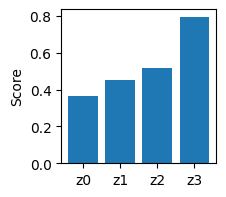

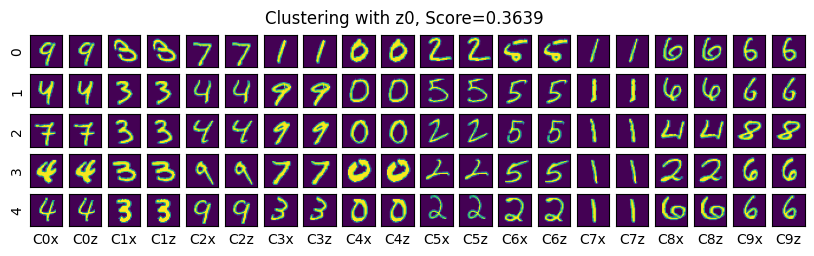

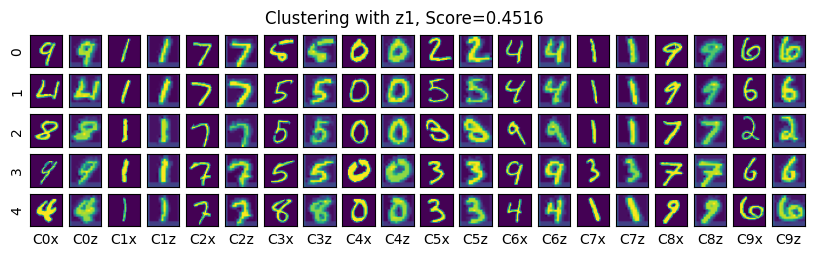

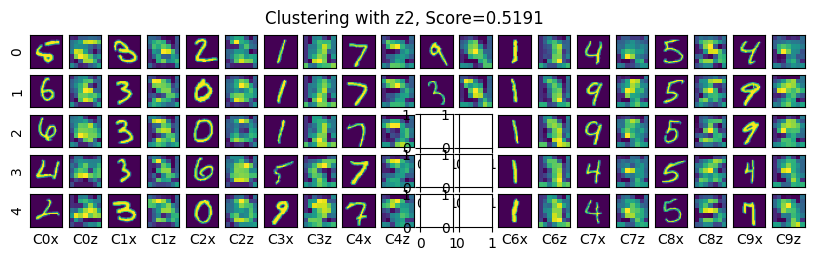

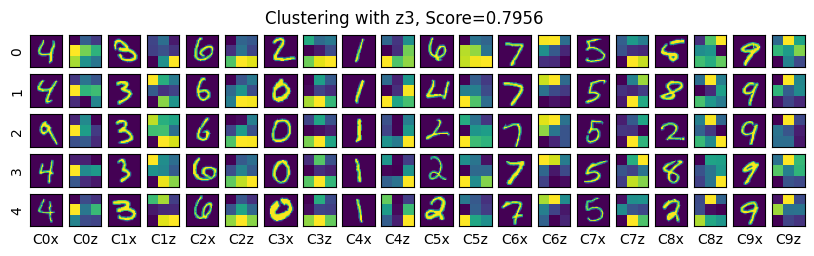

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


def cluster_and_score(z, true_labels):
    # ----------- <Your code> ---------------
    kmeans = KMeans(n_clusters=10, random_state=0).fit(z.reshape(z.shape[0], -1))
    cluster_labels = kmeans.labels_
    score = adjusted_rand_score(true_labels, cluster_labels)
    # ----------- <End your code> ---------------
    return cluster_labels, score


fig = plt.figure(figsize=(2, 2))
plt.bar(
    [f"z{zi}" for zi in range(len(z_list_test))],
    [cluster_and_score(z_test, labels_test)[1] for z_test in z_list_test],
)
plt.ylabel("Score")
for zi, z_test in enumerate(z_list_test):
    cluster_labels, score = cluster_and_score(z_test, labels_test)
    plot_cluster(cluster_labels, z_test, f"Clustering with z{zi}, Score={score:.4f}")


Notice how the 3x3 pattern for the last representation looks similar across the samples.

# Exercise 3: Nearest neigbhors methods using representations (10 points)

### Task 1: Compute and plot nearest neigbhors in different representations

We will now compute the 1 nearest neighbor (i.e., `n_neighbors=1`) of test points compared to train points in different representations.

* Loop through the representations for the train and test numpy arrays (i.e., `z_list_train` and `z_list_test`).
* For each representaiton from the different layers, compute the *training* indices corresponding to the nearest neighbor of first 15 *testing* indices.
* Plot the neighbors by passing the test indices and corresponding nearest neighbor training indices along with the corresponding train and test representations and a title that describes which representation into `plot_neighbor`.

Notes:
* See note above about reshaping tensors immediately before passing to scikit-learn functions which expect a matrix.
* The `sklearn.neighbors.NearestNeighbors` class and the `kneighbors` method may be very helpful. The data that is passed to `fit` will be the training data and the data passed to `kneighbors` should be the new test data.
* The test indices should just be `np.arange(15)` assuming that you find the nearest training points for the first 15 points in the test dataset.

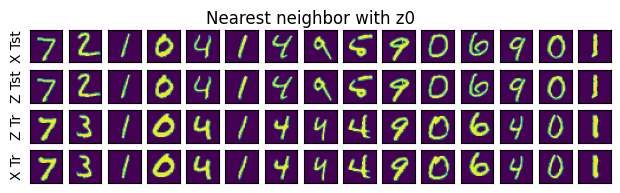

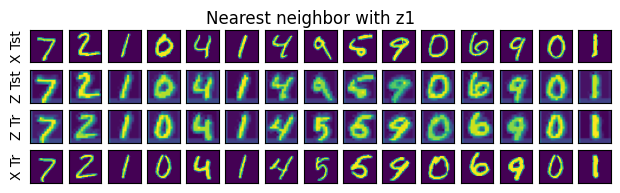

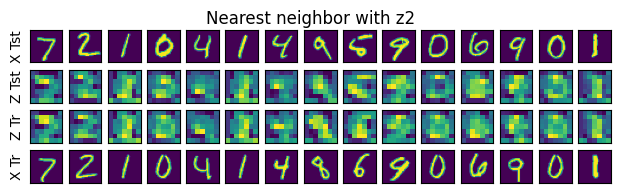

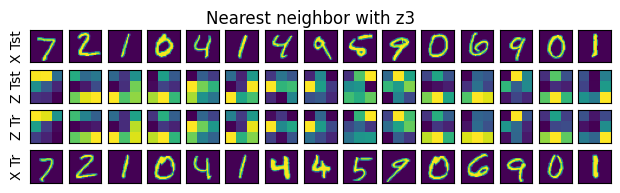

In [63]:
def plot_neigbhor(test_ind, nearest_train_ind, z_test, z_train, title):
    """
    Plots the original test image, the test image representation,
      the nearest train image representation, the nearest original train image.
    """
    assert len(test_ind) == len(
        nearest_train_ind
    ), "Test and train indices should be the same length"
    n_test = len(test_ind)
    fig, axes_mat = plt.subplots(4, n_test, figsize=np.array([n_test, 4]) / 2)
    for test_i, nearest_train_i, axes in zip(test_ind, nearest_train_ind, axes_mat.T):
        plot_representation(x_test[test_i], axes[0])
        plot_representation(z_test[test_i], axes[1])
        plot_representation(z_train[nearest_train_i], axes[2])
        plot_representation(x_train[nearest_train_i], axes[3])
        if test_i == 0:
            for lab, ax in zip(["X Tst", "Z Tst", "Z Tr", "X Tr"], axes):
                ax.set_ylabel(lab)
    fig.suptitle(title)


# ----------- <Your code> ---------------
from sklearn.neighbors import NearestNeighbors

num_samples = 15
n_neighbors = 1
test_indices = np.arange(num_samples)


def find_nearest_neighbor(test, train):
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(train)
    distances, indices = nn.kneighbors(test, n_neighbors=n_neighbors)
    return indices.flatten()


for z_test, z_train, z_name in zip(z_list_test, z_list_train, ["z0", "z1", "z2", "z3"]):
    # Take the first 15 samples from the test set
    z_test = z_test[:num_samples]
    nearest_train_ind = find_nearest_neighbor(
        z_test.reshape(z_test.shape[0], -1), z_train.reshape(z_train.shape[0], -1)
    )
    plot_neigbhor(
        test_indices,
        nearest_train_ind,
        z_test,
        z_train,
        f"Nearest neighbor with {z_name}",
    )

# ----------- <End your code> ---------------